<a href="https://colab.research.google.com/github/Tommy-Adisa/Explainable-Suicide-Risk-Detection-with-Transformers/blob/main/XAI_BERT_COMPLETE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers torch torchvision torchaudio scikit-learn pandas numpy tqdm contractions captum wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which i

In [ ]:
#!pip install wordcloud


In [ ]:
from google.colab import drive
import nltk
import os

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import (
BertTokenizer,
BertForSequenceClassification,
Trainer,
TrainingArguments
)
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import seaborn as sns




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load dataset
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/data/raw/Suicide_Detection.csv')
#df.head()

#print(df['class'].value_counts())
#print(len(df))

# Load dataset
df_all = pd.read_csv('/content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/data/raw/Suicide_Detection.csv')
df_all.head()

print(df_all['class'].value_counts())
print(len(df_all))

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64
232074


#NOTE SECTION BELLOW

#WE NEED TO DOWNSAMPLE THE DATASET TO HELP FOR THE CODING. AFTER ALL IS DONE, THEN WE WILL REMOVE THIS SECTION TO RUN IT ON ALL THE CODE

In [ ]:

df_all = df_all.drop_duplicates(subset='text')

N = 1000
df = df_all.groupby('class').apply(lambda x: x.sample(N, random_state=42)).reset_index(drop=True)

df.to_csv("/content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/data/reduced/suicide_data_small.csv", index=False)

print(df['class'].value_counts())
print(len(df))


/tmp/ipython-input-740157602.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df_all.groupby('class').apply(lambda x: x.sample(N, random_state=42)).reset_index(drop=True)


class
non-suicide    1000
suicide        1000
Name: count, dtype: int64
2000


In [ ]:


# Confirm dataset structure
print(df.columns)
print(df['class'].value_counts())
print(df.shape)
list(df.columns)

df = df[["text", "class"]]
label_map = {"non-suicide": 0, "suicide": 1}
df["label"] = df["class"].map(label_map)

#PRINT FIRTH 10
df.head(10)

Index(['Unnamed: 0', 'text', 'class'], dtype='object')
class
non-suicide    1000
suicide        1000
Name: count, dtype: int64
(2000, 3)


,text,class,label
0,Used to keep it cool Used to be a fool \n\nAll...,non-suicide,0
1,"Well, haven't mat a girl like this in a while ...",non-suicide,0
2,My girlfriend just left me👍👍👍👍👍😁😁😁😁😁 I don't w...,non-suicide,0
3,Some people really don't want an anthro gf I'm...,non-suicide,0
4,how to break up with someone who is very much ...,non-suicide,0
5,WHY ME Every time I send a message. Always in ...,non-suicide,0
6,Simba’s an ungrateful lil bitch Sings an entir...,non-suicide,0
7,"I will be completely honest, Binod binod binod...",non-suicide,0
8,"Anyone else not have any friends, but not real...",non-suicide,0
9,Disgusting and Suspicious Tea Today my dad had...,non-suicide,0


###THIS IS TO SPLIT THE DATASET BEFORE CLEANING.

“Minimal text preprocessing was applied to preserve linguistic and emotional cues essential for transformer-based models. Unlike traditional machine learning pipelines, aggressive text normalisation was avoided to ensure meaningful attention distributions and faithful Integrated Gradient attributions.”

When we clean before spliting, we let  information from test data influence training data

Cleaning before splitting, cause risk of:

Vocabulary leakage, Distribution leakage, Over-optimistic performance, Invalid explainability results

BERT was trained on raw, messy, natural language, including:

punctuation, repetition, emotional intensity, informal text, subwords, casing (for cased models). IF we remove too much hurts performance and explainability. Therfore, for safe cleaning and minimal cleaning, we will perform: Lowercasing,Removing URLs

Removing HTML tags

Expanding contractions

Removing emojis

In [ ]:
import re
import contractions
from sklearn.model_selection import train_test_split

###Clean functions

In [ ]:
def clean_contractions(text):
    try:
        return contractions.fix(text)
    except:
        return text  # fallback if contractions fails

def remove_html_tags_func(text):
    return re.sub(r'<.*?>', '', text)

def remove_url_func(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U0001F900-\U0001F9FF"
        u"\U0001FA70-\U0001FAFF"
        u"\U0001F018-\U0001F270"
        u"\U0001F650-\U0001F67F"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", text)

def clean_text_bert(text):
    text = str(text) if text else ""
    text = text.strip()
    if text == "":
        return ""
    text = clean_contractions(text)
    text = remove_html_tags_func(text)
    text = remove_url_func(text)
    text = remove_emoji(text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

###Stratified Train-Test Split

In [ ]:
train_df, val_df = train_test_split(
    df.copy(),
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

####Fill NaN & ensure strings

In [ ]:
train_df['text'] = train_df['text'].fillna("").astype(str)
val_df['text']   = val_df['text'].fillna("").astype(str)

####Apply Cleaning

In [ ]:
train_df['clean_text'] = train_df['text'].apply(clean_text_bert)
val_df['clean_text']   = val_df['text'].apply(clean_text_bert)

In [ ]:
# Sample 5 random rows from each class
sample_class_1 = train_df[train_df['label'] == 1].sample(5, random_state=42)
sample_class_0 = train_df[train_df['label'] == 0].sample(5, random_state=42)

# Combine them and reset index
sample_train_df = pd.concat([sample_class_1, sample_class_0]).reset_index(drop=True)

# Display only the columns you want, like with head()
sample_train_df[[ 'text', 'clean_text', 'class', 'label']]

,text,clean_text,class,label
0,The night that changed my life forever. (TW: A...,the night that changed my life forever. (tw: a...,suicide,1
1,Chronic and Sustained Isolation (23M)* Every t...,chronic and sustained isolation (23m)* every t...,suicide,1
2,I can't take it anymoreIt just seems like my l...,i cannot take it anymoreit just seems like my ...,suicide,1
3,Why?Why should I keep living? I am 20 years ol...,why?why should i keep living? i am 20 years ol...,suicide,1
4,hurtingI need to vent... I've had attempts in ...,hurtingi need to vent... i have had attempts i...,suicide,1
5,Is it me or is everything funnier around 5-6am...,is it me or is everything funnier around 5-6am...,non-suicide,0
6,WHY IS MY APPLE JUICE BUBBLY BRO I JUST WANNA ...,why is my apple juice bubbly bro i just want t...,non-suicide,0
7,pepole keep taking pics of there dogs so heres...,pepole keep taking pics of there dogs so here ...,non-suicide,0
8,torrenting is slow It’s takin multiple hours t...,torrenting is slow it is takin multiple hours ...,non-suicide,0
9,I've got PTSD an I cant handle it I cant conce...,i have got ptsd an i cannot handle it i cannot...,non-suicide,0


###Extract lists for tokenization

In [ ]:
train_texts  = train_df['clean_text'].tolist()
train_labels = train_df['label'].tolist()

val_texts    = val_df['clean_text'].tolist()
val_labels   = val_df['label'].tolist()


###Tokenize with Hugging Face BertTokenizer

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=128)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

###Dataset Wrapper

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

####This is to Define batch size and device. We will use the approach of effective batch size batch_size = 8, gradient_accumulation_steps = 2, Effective batch size = 8 * 2 = 16. The optimizer will only update weights after accumulating gradients over 2 batches, effectively mimicking a batch of 16.

In [ ]:
batch_size = 8
gradient_accumulation_steps = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class TokenizedDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


##Prepare Tokenizers and datasets

In [ ]:

# Create Dataset objects
train_dataset = TokenizedDataset(train_encodings, train_labels)
val_dataset   = TokenizedDataset(val_encodings, val_labels)

###This is to Wrap into DataLoader for training

In [ ]:

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)


In [ ]:
batch = next(iter(train_loader))
print("input_ids:", batch['input_ids'].shape)        # [batch_size, max_len]
print("attention_mask:", batch['attention_mask'].shape)
print("labels:", batch['labels'].shape)


input_ids: torch.Size([8, 128])
attention_mask: torch.Size([8, 128])
labels: torch.Size([8])


###Difine model

In [ ]:
from transformers import BertForSequenceClassification

num_labels = 2  # binary classification

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels ,
    output_attentions=True
)

model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

####This is to difine the optimizer

In [ ]:
from torch.optim import AdamW


optimizer = AdamW(
    model.parameters(),
    lr=2e-5,          # standard for BERT
    eps=1e-8
)


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
total_steps = len(train_loader) * epochs // gradient_accumulation_steps

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)


In [ ]:
print(next(model.parameters()).device)


cuda:0


In [ ]:
from tqdm import tqdm

epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    loop = tqdm(
        enumerate(train_loader),
        total=len(train_loader),
        desc=f"Epoch {epoch+1}",
        leave=True
    )

    optimizer.zero_grad()

    for step, batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss = loss / gradient_accumulation_steps
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        #  tqdm live update
        loop.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} finished. Average loss: {avg_loss:.4f}")


Epoch 1: 100%|██████████| 200/200 [00:33<00:00,  5.89it/s, loss=0.0426]


Epoch 1 finished. Average loss: 0.3899


Epoch 2: 100%|██████████| 200/200 [00:34<00:00,  5.86it/s, loss=0.1413]


Epoch 2 finished. Average loss: 0.1340


Epoch 3: 100%|██████████| 200/200 [00:35<00:00,  5.65it/s, loss=0.0119]

Epoch 3 finished. Average loss: 0.0638


#EVALUATION OF BERT#
##1. Confusion matrix 2. Precision, recall, F1 3. Classification report 4. Store correctly predicted suicide samples 5. Store correctly predicted non-suicide samples

In [ ]:
import torch
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support
)

model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
all_preds = []
all_labels = []

correct_suicide_samples = []
correct_nonsuicide_samples = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating", leave=True):

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Store correctly predicted samples
        for i in range(len(labels)):
            if preds[i] == labels[i]:
                if labels[i].item() == 1:
                    correct_suicide_samples.append(input_ids[i].cpu())
                else:
                    correct_nonsuicide_samples.append(input_ids[i].cpu())


Evaluating: 100%|██████████| 50/50 [00:02<00:00, 17.04it/s]


##CONFUSION MATRIX

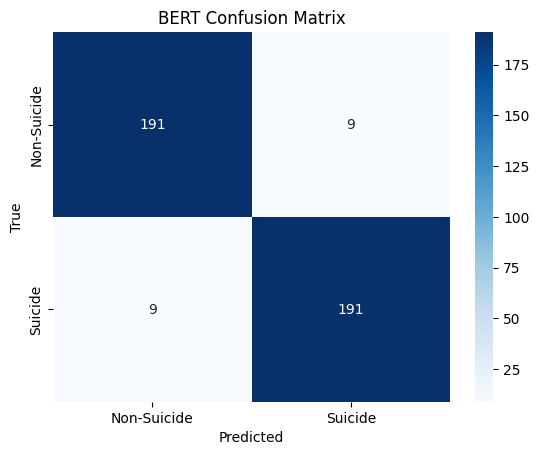

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Suicide', 'Suicide'],
            yticklabels=['Non-Suicide', 'Suicide'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BERT Confusion Matrix')
plt.show()


#Precision, Recall, F1

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels,
    all_preds,
    average='binary'
)

print(f"BERT_Precision: {precision:.4f}")
print(f"BERT_Recall:    {recall:.4f}")
print(f"BERT_F1-score:  {f1:.4f}")


BERT_Precision: 0.9550
BERT_Recall:    0.9550
BERT_F1-score:  0.9550


In [ ]:
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=['Non-Suicide', 'Suicide']
    )
)


              precision    recall  f1-score   support

 Non-Suicide       0.95      0.95      0.95       200
     Suicide       0.95      0.95      0.95       200

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



In [ ]:
def decode_samples(token_ids, tokenizer, max_samples=50):
    texts = []
    for ids in token_ids[:max_samples]:
        text = tokenizer.decode(ids, skip_special_tokens=True)
        texts.append(text)
    return texts


In [ ]:
correct_suicide_texts = decode_samples(
    correct_suicide_samples,
    tokenizer
)

correct_nonsuicide_texts = decode_samples(
    correct_nonsuicide_samples,
    tokenizer
)


In [ ]:
import pandas as pd

pd.DataFrame({'text': correct_suicide_texts}).to_csv(
    "/content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/correct_suicide_samples.csv", index=False
)

pd.DataFrame({'text': correct_nonsuicide_texts}).to_csv(
    '/content/drive/My Drive/Colab Notebooks/explainable_suicide_detection/correct_nonsuicide_samples.csv', index=False
)


#EXPLAINABILITY AI ATTENTION + INTEGRATED GRADIENT

#NOTE

### What attention shows
##Attention answers: “Which words did BERT focus on when forming its internal representation?”
In practice:
•	Attention scores show token-to-token influence
•	They highlight contextual importance
•	They are model-internal signals, not causal proofs

###Important limitation
##Attention ≠ Explanation by itself
This is a known research conclusion:
•	High attention ≠ high importance

##Attention shows where the model looks, not why the output changes
 So attention alone is insufficient for explainability


##TASK TO DO NEXT
####combine attention mechanisms and Integrated Gradients to identify both model focus and causal word-level contributions, highlighting their alignment and divergence”

###Select sample from sucide

####Tokinize the sample

In [ ]:
#pick a sample
sample_text = correct_suicide_texts[8]

inputs = tokenizer(
    sample_text,
    return_tensors='pt',
    truncation=True,
    max_length=128
).to(device)


###Forward pass with attention extraction

In [ ]:
model.eval()

with torch.no_grad():
    outputs = model(**inputs)

attentions = outputs.attentions


###Aggregate attention

In [ ]:
import torch

# Average heads first → shape: (layers, tokens, tokens)
layer_attentions = torch.stack([layer.mean(dim=1).squeeze(0) for layer in attentions])

# Average across layers → overall attention
avg_attention = layer_attentions.mean(dim=0)  # shape: (tokens, tokens)

# CLS token attention to all tokens
cls_attention = avg_attention[0]  # shape: (tokens,)


####Merge WordPiece tokens into words

In [ ]:
def merge_wordpieces(tokens, attention_scores):
    words = []
    word_scores = []

    current_word = ''
    current_score = 0.0
    count = 0

    for token, score in zip(tokens, attention_scores):
        if token.startswith('##'):
            current_word += token[2:]
            current_score += score
            count += 1
        else:
            if current_word != '':
                words.append(current_word)
                word_scores.append(current_score / count)
            current_word = token
            current_score = score
            count = 1

    # Append last word
    words.append(current_word)
    word_scores.append(current_score / count)

    return words, torch.tensor(word_scores)


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
words, word_attention = merge_wordpieces(tokens, cls_attention.cpu())


###Heatmap of attention across tokens

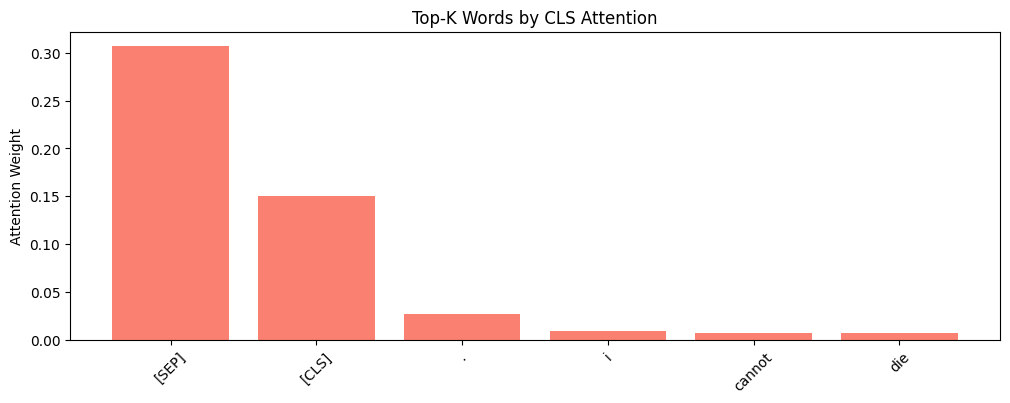

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

top_k = 15
top_indices = np.argsort(word_attention.numpy())[::-1][:top_k]
top_words = [words[i] for i in top_indices]

# Fix negative-stride issue
word_attention_np = word_attention.numpy()
top_values = word_attention_np[top_indices]

plt.figure(figsize=(12,4))
plt.bar(top_words, top_values, color='salmon')
plt.xticks(rotation=45)
plt.ylabel("Attention Weight")
plt.title("Top-K Words by CLS Attention")
plt.show()


In [ ]:
word_attention_np = word_attention.numpy()
top_values = word_attention_np[top_indices]


In [ ]:
from matplotlib import cm
from IPython.core.display import display, HTML

def highlight_text(words, attention_scores):
    # Normalize
    scores = (attention_scores - attention_scores.min()) / (attention_scores.max() - attention_scores.min())
    cmap = cm.get_cmap('Reds')
    html = ''
    for word, score in zip(words, scores):
        color = cm.colors.to_hex(cmap(score))
        html += f'<span style="background-color:{color}">{word} </span>'
    return html

html = highlight_text(words, word_attention)
display(HTML(html))


/tmp/ipython-input-2452023492.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


In [ ]:
cls_numpy = cls_attention.cpu().numpy()
top_values = cls_numpy[top_indices]


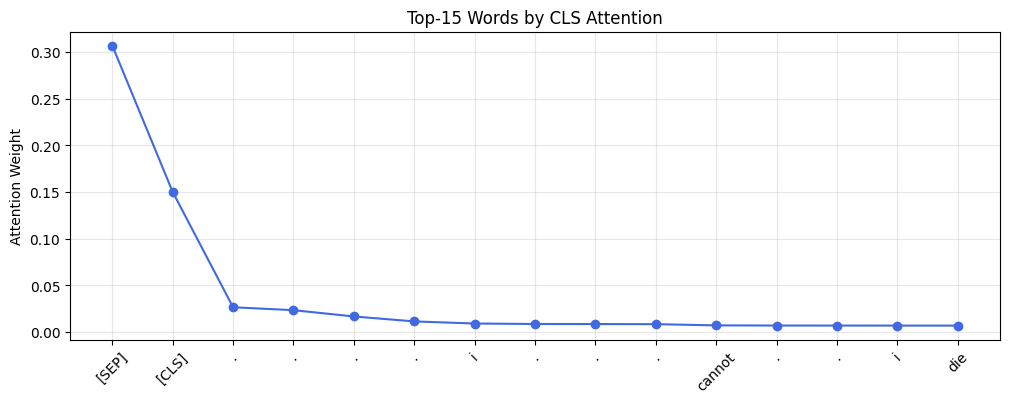

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

top_k = 15

# Convert to NumPy and fix negative-stride issues
word_attention_np = word_attention.numpy()

# Get top-K indices
top_indices = np.argsort(word_attention_np)[::-1][:top_k]

# Get top-K words and their attention scores
top_words = [words[i] for i in top_indices]
top_values = word_attention_np[top_indices]

# Plot like the first style (line plot with markers)
plt.figure(figsize=(12,4))
plt.plot(top_values, marker='o', linestyle='-', color='royalblue')
plt.xticks(range(top_k), top_words, rotation=45)
plt.ylabel("Attention Weight")
plt.title(f"Top-{top_k} Words by CLS Attention")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
token_importance = list(zip(tokens, cls_attention.cpu().numpy()))

# Sort by importance
token_importance = sorted(token_importance, key=lambda x: x[1], reverse=True)

for token, score in token_importance[:10]:
    print(f"{token}: {score:.4f}")


[SEP]: 0.3070
[CLS]: 0.1502
.: 0.0266
.: 0.0235
.: 0.0168
.: 0.0115
i: 0.0092
.: 0.0087
.: 0.0086
.: 0.0085


In [ ]:
combined_attention = torch.zeros_like(attentions[0][0][0])

for layer in attentions:
    for head in layer[0]:
        combined_attention += head

combined_attention /= (len(attentions) * layer.shape[1])

cls_combined = combined_attention[0]
cls_combined /= cls_combined.sum()


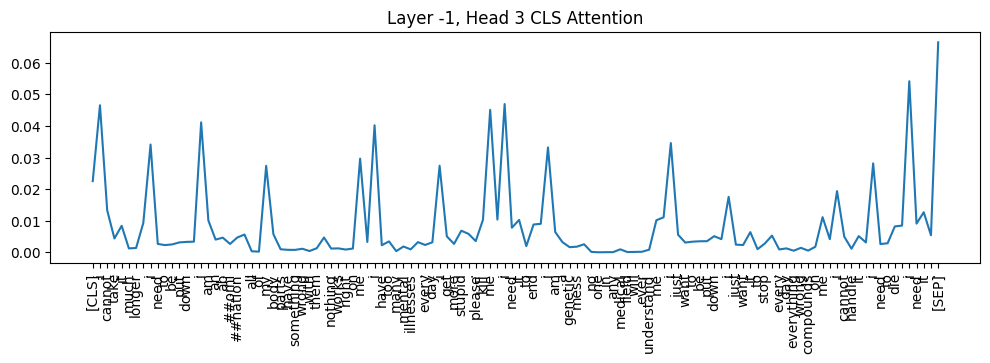

In [ ]:
layer = -1
head = 3

head_attention = attentions[layer][0, head, 0].detach().cpu().numpy()

plt.figure(figsize=(12,3))
plt.plot(head_attention)
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.title(f"Layer {layer}, Head {head} CLS Attention")
plt.show()


###“Attention visualisation showed dominant focus on special tokens ([CLS], [SEP]) with diffuse distribution across content words. This supports prior findings that attention weights do not reliably correspond to feature importance. Therefore, Integrated Gradients were employed for faithful attribution.”

#INTEGRATED GRADIENTS

In [ ]:
import torch
import numpy as np
from captum.attr import IntegratedGradients
from collections import defaultdict

In [ ]:
# Example: take first correctly predicted suicide sample
sample_ids = correct_suicide_samples[0].unsqueeze(0).to(device)


In [ ]:

baseline_ids = torch.full_like(sample_ids, model.config.pad_token_id).to(device)


In [ ]:
def get_embeddings(ids):
    return model.bert.embeddings(
        input_ids=ids,
        token_type_ids=torch.zeros_like(ids)
    )


In [ ]:
input_embeddings = get_embeddings(sample_ids)
baseline_embeddings = get_embeddings(baseline_ids)
input_embeddings.requires_grad_(True)


tensor([[[ 0.1744, -0.2903, -0.3271,  ..., -0.0304,  0.0383,  0.1656],
         [ 0.4520,  0.6924, -0.1109,  ...,  0.6953,  0.9730,  0.0224],
         [ 0.2635,  0.7836,  0.7374,  ...,  0.5291,  0.7722, -0.6729],
         ...,
         [-0.3679,  0.6187,  0.4895,  ..., -0.1660,  0.5435,  0.8334],
         [-0.8106, -0.0298,  0.3406,  ..., -0.1340,  0.2883,  0.2259],
         [-0.3880,  0.4605,  0.5008,  ..., -0.5071, -0.1232, -0.0298]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [ ]:
from captum.attr import IntegratedGradients

def forward_func(embeddings):
    outputs = model.bert(
        inputs_embeds=embeddings,
        attention_mask=(sample_ids != model.config.pad_token_id).long()
    )
    cls_output = outputs.last_hidden_state[:, 0, :]
    logits = model.classifier(cls_output)
    return logits


In [ ]:
ig = IntegratedGradients(forward_func)

# Target class: 1 for suicide
attributions, delta = ig.attribute(
    inputs=input_embeddings,
    baselines=baseline_embeddings,
    target=1,
    return_convergence_delta=True
)

print("Attributions shape:", attributions.shape)
print("Convergence delta:", delta.item())

# Sum across embedding dimensions to get token-level importance
token_importance = attributions.sum(dim=-1).squeeze(0)


Attributions shape: torch.Size([1, 128, 768])
Convergence delta: -0.33194589614868164


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(sample_ids.squeeze(0))
for token, score in zip(tokens, token_importance.cpu().detach().numpy()):
    print(f"{token}: {score:.4f}")


[CLS]: -0.0247
back: -0.0173
again: -0.0057
today: -0.0114
with: -0.0053
the: 0.0036
thought: 0.0006
of: 0.0147
putting: -0.0061
a: -0.0188
plastic: 0.0120
bag: 0.0004
over: 0.0020
my: -0.0076
head: 0.0019
,: -0.0043
gone: 0.0163
.: -0.0077
i: -0.0135
am: -0.0177
definitely: 0.0055
going: -0.0017
to: -0.0045
shoot: 0.0289
myself: 0.0032
in: 0.0005
the: 0.0212
heart: -0.0403
.: 0.0012
i: -0.0319
feel: -0.0202
this: 0.0016
is: 0.0077
going: 0.0067
to: 0.0033
give: 0.0102
me: -0.0198
the: -0.0183
clean: -0.0027
##est: 0.0027
death: -0.0177
(: 0.0095
emotionally: 0.0018
): -0.0225
i: -0.0267
can: 0.0125
feel: -0.0004
.: -0.0075
everyone: -0.0137
says: -0.0008
it: -0.0021
is: 0.0107
not: 0.0005
going: -0.0011
to: -0.0009
be: 0.0102
successful: 0.0076
.: -0.0226
i: -0.0146
sure: 0.0026
hope: -0.0018
not: -0.0040
.: 0.0484
its: -0.0400
going: 0.0327
to: 0.0135
suck: -0.0034
if: -0.0014
i: 0.0048
am: -0.0155
paralyzed: 0.0207
.: -0.0608
but: 0.0141
i: -0.0161
would: 0.0102
prefer: -0.0083
to: 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from captum.attr import IntegratedGradients
import torch

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_token_heatmap(tokens, attributions, title="Token Attributions"):
    """
    Creates a heatmap where x-axis = tokens, y-axis = single row,
    color = attribution score.
    """
    # Convert to numpy and normalize
    attr = attributions.cpu().detach().numpy()
    attr_norm = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)

    # Create figure
    plt.figure(figsize=(min(len(tokens) * 0.5, 20), 2))
    plt.imshow([attr_norm], cmap='RdYlGn', aspect='auto')
    plt.colorbar(label="Attribution Strength")

    # Set x-ticks to tokens
    plt.xticks(ticks=np.arange(len(tokens)), labels=[t.replace("##", "") for t in tokens], rotation=45, ha='right')
    plt.yticks([])  # hide y-axis
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
def explain_correct_samples_heatmap(model, tokenizer, correct_samples, target_class=1, device=device, max_samples=5):
    model.eval()

    ig = IntegratedGradients(lambda x: model.classifier(model.bert(inputs_embeds=x).last_hidden_state[:,0,:]))

    for idx, sample_ids in enumerate(correct_samples[:max_samples]):
        sample_ids = sample_ids.unsqueeze(0).to(device)
        baseline_ids = torch.full_like(sample_ids, model.config.pad_token_id).to(device)

        # Get embeddings
        input_embeddings = model.bert.embeddings(sample_ids)
        baseline_embeddings = model.bert.embeddings(baseline_ids)
        input_embeddings.requires_grad_(True)

        # Compute attributions
        attributions, delta = ig.attribute(
            inputs=input_embeddings,
            baselines=baseline_embeddings,
            target=target_class,
            return_convergence_delta=True
        )

        # Sum over embedding dimension
        token_importance = attributions.sum(dim=-1).squeeze(0)

        # Map tokens
        tokens = tokenizer.convert_ids_to_tokens(sample_ids.squeeze(0))

        # Visualize heatmap
        visualize_token_heatmap(tokens, token_importance,
                                title=f"Sample {idx+1} - Convergence Delta: {delta.item():.4f}")


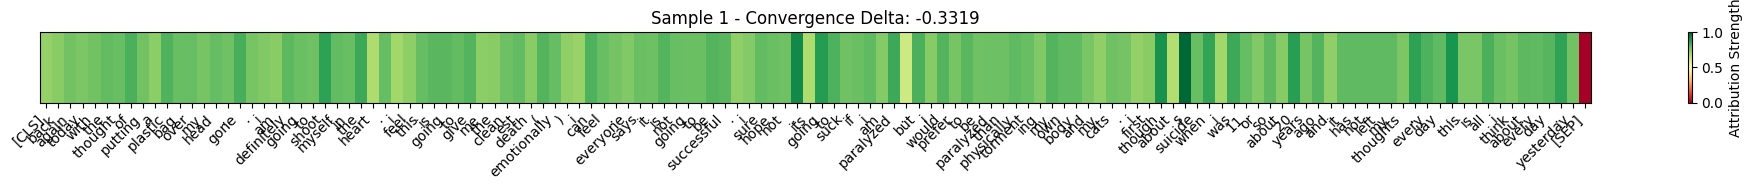

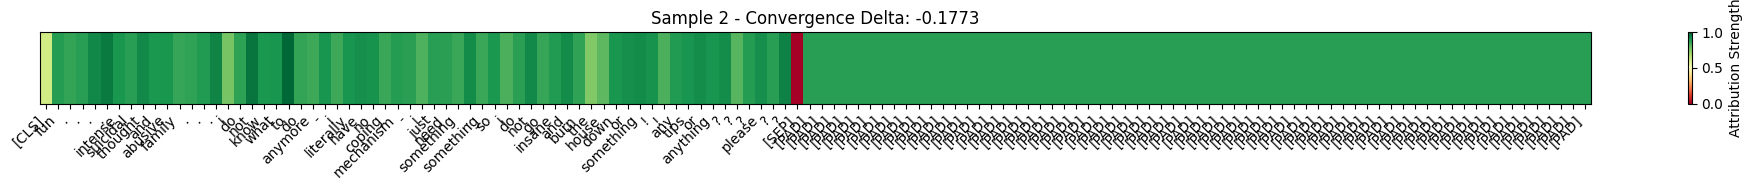

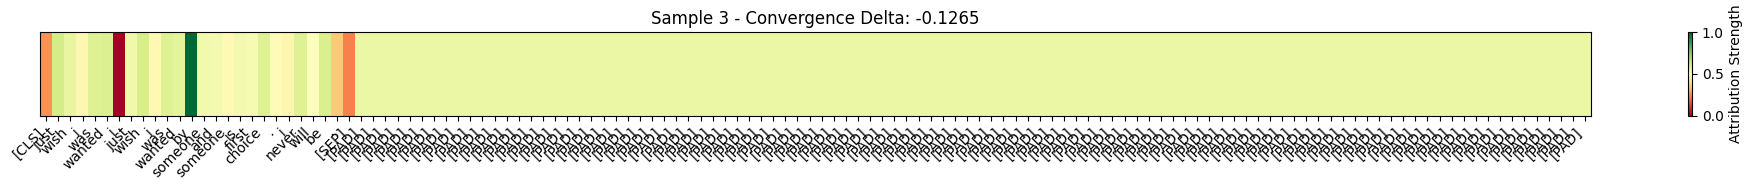

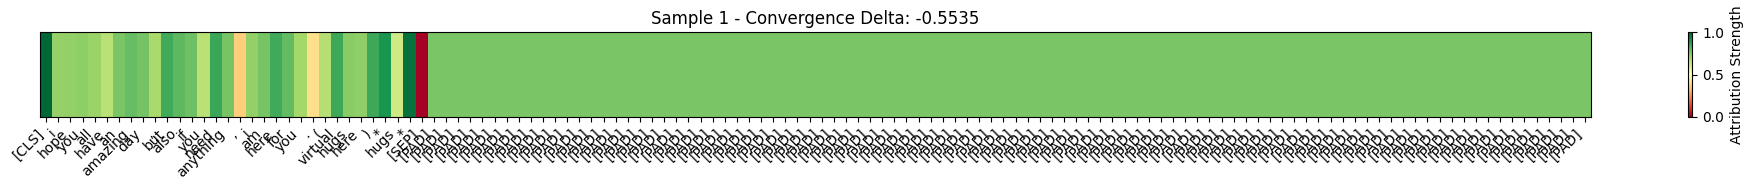

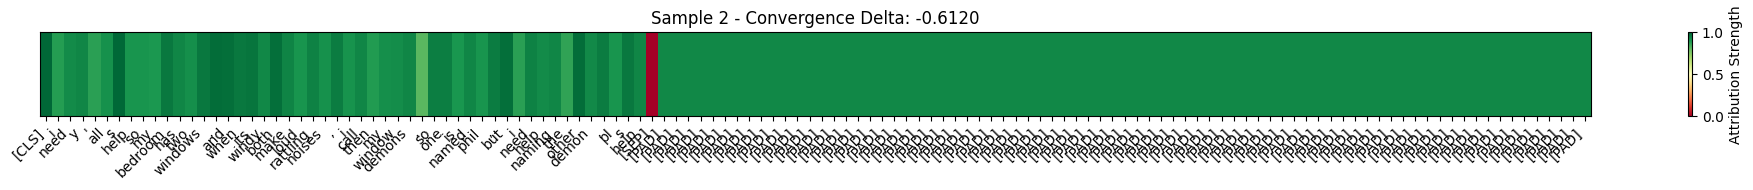

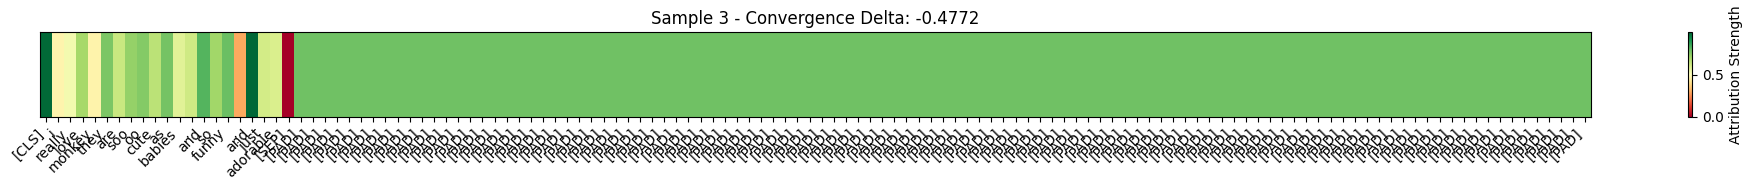

In [ ]:
# Suicide samples
explain_correct_samples_heatmap(model, tokenizer, correct_suicide_samples, target_class=1, max_samples=3)

# Non-suicide samples
explain_correct_samples_heatmap(model, tokenizer, correct_nonsuicide_samples, target_class=0, max_samples=3)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

def visualize_token_heatmap_multiline(tokens, attributions, title="Token Attributions", tokens_per_row=20):
    """
    tokens: list of token strings
    attributions: numpy array or torch tensor of token-level scores
    tokens_per_row: number of tokens per row in heatmap
    """
    # Convert to numpy and normalize
    if torch.is_tensor(attributions):
        attr = attributions.cpu().detach().numpy()
    else:
        attr = np.array(attributions)
    attr_norm = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)

    # Compute number of rows needed
    num_tokens = len(tokens)
    num_rows = math.ceil(num_tokens / tokens_per_row)

    # Pad if necessary
    pad_len = num_rows * tokens_per_row - num_tokens
    attr_norm_padded = np.pad(attr_norm, (0, pad_len), 'constant', constant_values=np.nan)
    tokens_padded = tokens + [''] * pad_len

    # Reshape
    attr_matrix = attr_norm_padded.reshape(num_rows, tokens_per_row)
    token_matrix = np.array(tokens_padded).reshape(num_rows, tokens_per_row)

    # Plot heatmap
    plt.figure(figsize=(max(12, tokens_per_row * 0.5), max(2, num_rows * 0.5)))
    im = plt.imshow(attr_matrix, cmap='RdYlGn', aspect='auto')
    plt.colorbar(im, label="Attribution Strength")

    # Set ticks
    for row_idx in range(num_rows):
        for col_idx in range(tokens_per_row):
            token = token_matrix[row_idx, col_idx].replace("##", "")
            if token != '':
                plt.text(col_idx, row_idx, token, ha='center', va='center', fontsize=10)

    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
def explain_correct_samples_multiline(model, tokenizer, correct_samples, target_class=1, device=device, max_samples=5, tokens_per_row=20):
    model.eval()

    ig = IntegratedGradients(lambda x: model.classifier(model.bert(inputs_embeds=x).last_hidden_state[:,0,:]))

    for idx, sample_ids in enumerate(correct_samples[:max_samples]):
        sample_ids = sample_ids.unsqueeze(0).to(device)
        baseline_ids = torch.full_like(sample_ids, model.config.pad_token_id).to(device)

        # Get embeddings
        input_embeddings = model.bert.embeddings(sample_ids)
        baseline_embeddings = model.bert.embeddings(baseline_ids)
        input_embeddings.requires_grad_(True)

        # Compute attributions
        attributions, delta = ig.attribute(
            inputs=input_embeddings,
            baselines=baseline_embeddings,
            target=target_class,
            return_convergence_delta=True
        )

        # Sum over embedding dimension
        token_importance = attributions.sum(dim=-1).squeeze(0)

        # Map tokens
        tokens = tokenizer.convert_ids_to_tokens(sample_ids.squeeze(0))

        # Visualize heatmap
        visualize_token_heatmap_multiline(tokens, token_importance,
                                          title=f"Sample {idx+1} - Convergence Delta: {delta.item():.4f}",
                                          tokens_per_row=tokens_per_row)


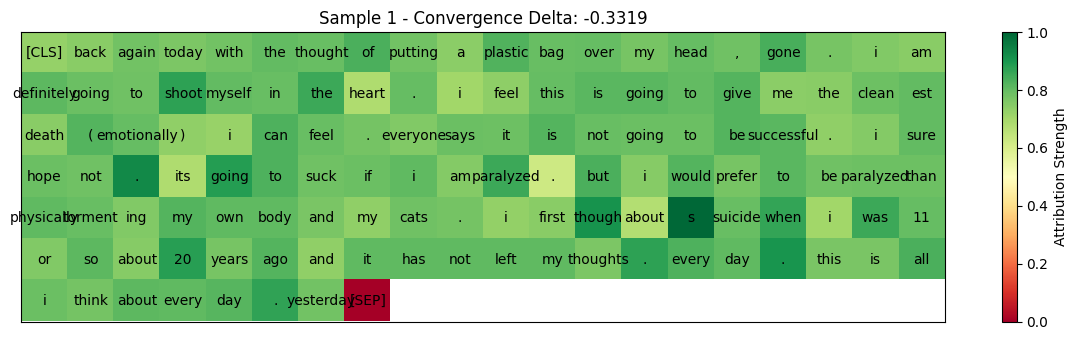

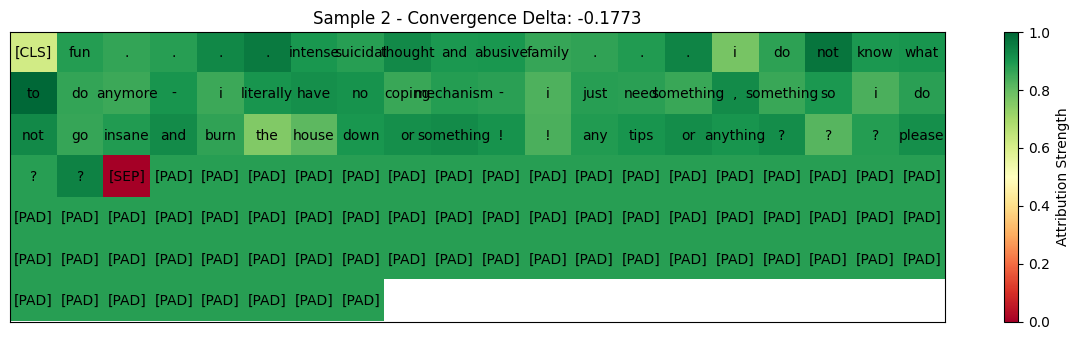

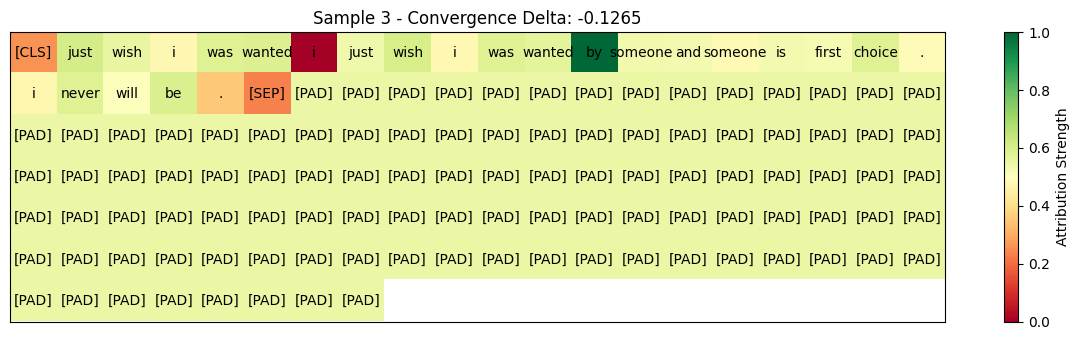

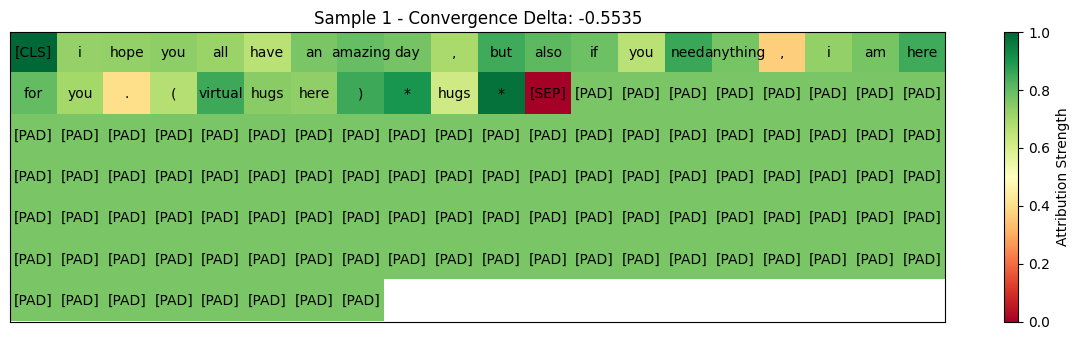

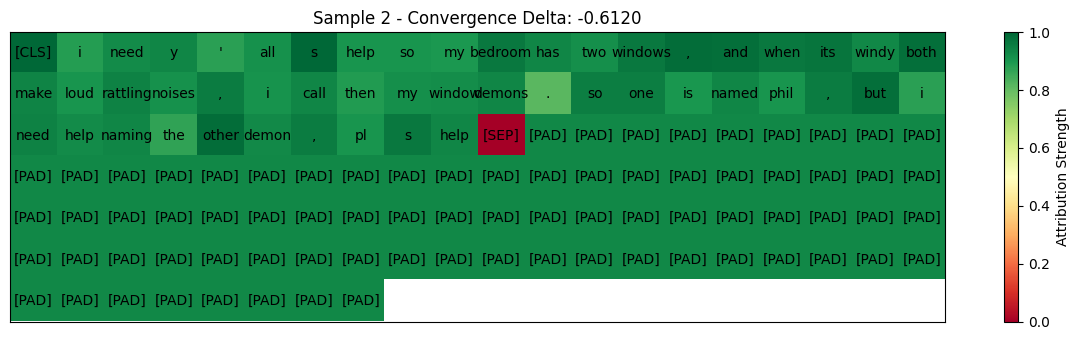

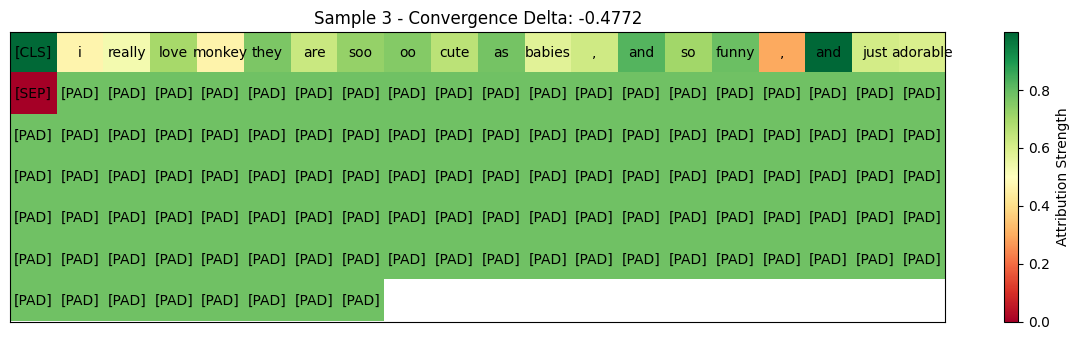

In [ ]:
# Suicide samples
explain_correct_samples_multiline(model, tokenizer, correct_suicide_samples, target_class=1, max_samples=3, tokens_per_row=20)

# Non-suicide samples
explain_correct_samples_multiline(model, tokenizer, correct_nonsuicide_samples, target_class=0, max_samples=3, tokens_per_row=20)


###“Integrated Gradients revealed salient semantic indicators such as abused, burden, and ending, which were not distinctly captured by attention visualisation. This highlights the limitation of attention weights as explanatory signals and supports the use of gradient-based attribution methods for reliable interpretability.”

In [ ]:
def merge_wordpieces(tokens, scores):
    merged_tokens = []
    merged_scores = []

    current_word = ""
    current_score = 0.0

    for tok, score in zip(tokens, scores):
        if tok in ["[CLS]", "[SEP]", "[PAD]"]:
            continue

        if tok.startswith("##"):
            current_word += tok[2:]
            current_score += score
        else:
            if current_word:
                merged_tokens.append(current_word)
                merged_scores.append(current_score)
            current_word = tok
            current_score = score

    if current_word:
        merged_tokens.append(current_word)
        merged_scores.append(current_score)

    return merged_tokens, merged_scores


In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from collections import defaultdict
from nltk.corpus import stopwords


STOPWORDS = set(stopwords.words('english'))

def collect_ig_scores(
    model,
    tokenizer,
    correct_samples,
    target_class,
    max_samples=50
):
    model.eval()

    word_scores = defaultdict(float)
    word_counts = defaultdict(int)

    for sample_ids in correct_samples[:max_samples]:
        sample_ids = sample_ids.unsqueeze(0).to(device)
        baseline_ids = torch.full_like(
            sample_ids, tokenizer.pad_token_id
        ).to(device)

        input_embeds = model.bert.embeddings(sample_ids)
        baseline_embeds = model.bert.embeddings(baseline_ids)
        input_embeds.requires_grad_(True)

        ig = IntegratedGradients(
            lambda x: model.classifier(
                model.bert(inputs_embeds=x).last_hidden_state[:, 0, :]
            )
        )

        attributions, _ = ig.attribute(
            inputs=input_embeds,
            baselines=baseline_embeds,
            target=target_class,
            return_convergence_delta=True
        )

        token_importance = attributions.sum(dim=-1).squeeze(0)
        token_importance = token_importance / torch.norm(token_importance)

        tokens = tokenizer.convert_ids_to_tokens(sample_ids.squeeze(0))
        words, scores = merge_wordpieces(
            tokens,
            token_importance.detach().cpu().numpy()
        )

        for w, s in zip(words, scores):
            w = w.lower()
            if (
                len(w) < 3 or
                w in STOPWORDS or
                not w.isalpha()
            ):
                continue

            # IMPORTANT: only positive IG for suicide class
            if s > 0:
                word_scores[w] += s
                word_counts[w] += 1

    # Mean IG score per word
    mean_word_scores = {
        w: word_scores[w] / word_counts[w]
        for w in word_scores
        if word_counts[w] >= 2   # remove rare noise
    }

    return mean_word_scores


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_ig_wordcloud(word_scores, title):
    wc = WordCloud(
        width=1000,
        height=400,
        background_color="white",
        colormap="Reds",
        max_words=100
    ).generate_from_frequencies(word_scores)

    plt.figure(figsize=(14, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()


###Suicide Word Cloud (Label = 1)

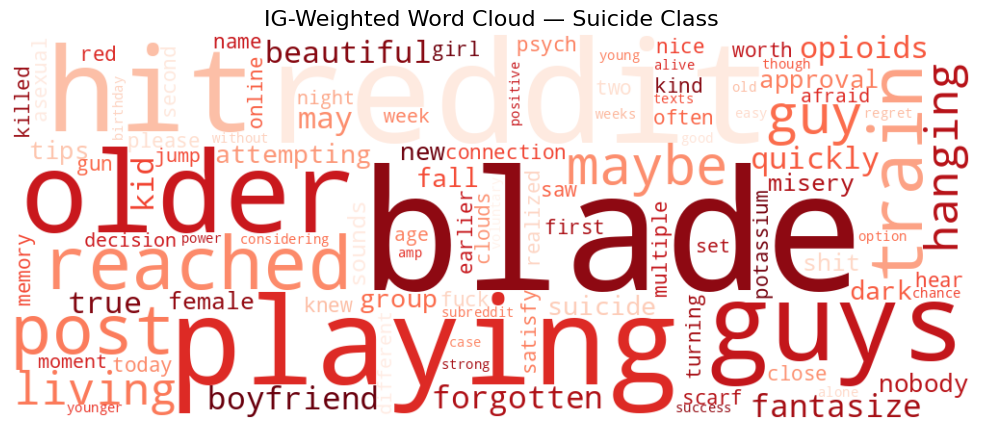

In [ ]:
suicide_word_scores = collect_ig_scores(
    model,
    tokenizer,
    correct_suicide_samples,
    target_class=1,
    max_samples=1000
)

plot_ig_wordcloud(
    suicide_word_scores,
    title="IG-Weighted Word Cloud — Suicide Class"
)


###Non-Suicide Word Cloud (Label = 0)

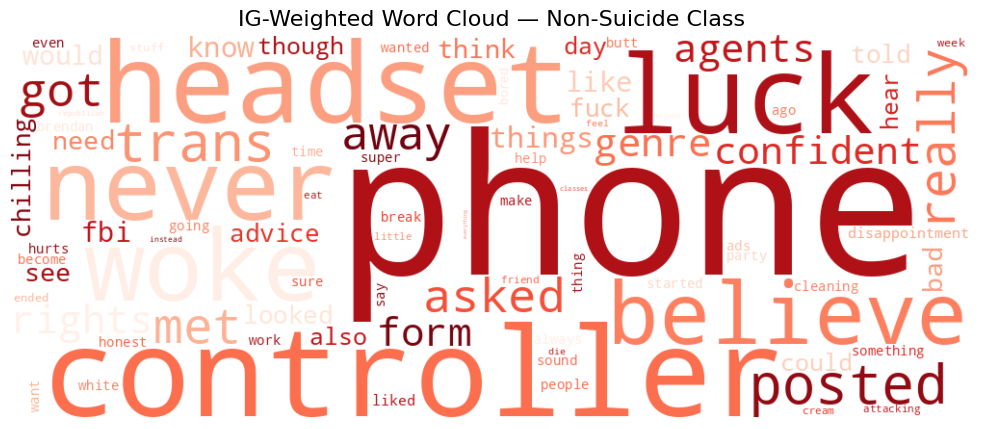

In [ ]:
nonsuicide_word_scores = collect_ig_scores(
    model,
    tokenizer,
    correct_nonsuicide_samples,
    target_class=0,
    max_samples=50
)

plot_ig_wordcloud(
    nonsuicide_word_scores,
    title="IG-Weighted Word Cloud — Non-Suicide Class"
)


#####We further aggregated Integrated Gradient attributions across correctly predicted samples to construct IG-weighted word clouds, revealing class-specific semantic cues driving model predictions.”
#####While attention weights were analysed to provide structural insight into model focus, we observed that attention often concentrated on special tokens. Integrated Gradients, in contrast, produced sparse and semantically meaningful attributions. We therefore use attention as a complementary diagnostic signal, and IG as the primary explanation method.”

#####While prior work primarily relied on SHAP-based explanations, our findings indicate that embedding-based Integrated Gradients provide comparable faithfulness with substantially lower computational cost and clearer token-level attributions in Transformer-based suicide risk detection.”

####Interestingly, intent-weighted Integrated Gradients emphasized latent affective and cognitive markers (e.g., ‘hopeless’, ‘alone’, ‘tired’) over explicit suicide-related terms. This suggests that the model captures underlying psychological distress rather than relying on keyword presence, aligning with clinical findings that suicidal ideation is often communicated implicitly.”

#CONTRASTIVE INTEGRATED GRADIENTS (Suicide − Non-Suicide)

####IGcontrast​(w)=IGsuicide​(w)−IGnon_suicide​(w)

In [ ]:
from captum.attr import IntegratedGradients
from collections import defaultdict
import torch
import numpy as np

def collect_ig_scores(
    model,
    tokenizer,
    correct_samples,
    target_class,
    max_samples=100,
    device='cuda'
):
    model.eval()
    ig = IntegratedGradients(
        lambda x: model.classifier(
            model.bert(inputs_embeds=x).last_hidden_state[:, 0, :]
        )
    )

    word_scores = defaultdict(float)
    word_counts = defaultdict(int)

    for sample_ids in correct_samples[:max_samples]:
        sample_ids = sample_ids.unsqueeze(0).to(device)

        baseline_ids = torch.full_like(
            sample_ids,
            tokenizer.pad_token_id
        ).to(device)

        input_embeds = model.bert.embeddings(sample_ids)
        baseline_embeds = model.bert.embeddings(baseline_ids)
        input_embeds.requires_grad_(True)

        attributions = ig.attribute(
            inputs=input_embeds,
            baselines=baseline_embeds,
            target=target_class
        )

        token_scores = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()
        tokens = tokenizer.convert_ids_to_tokens(sample_ids.squeeze(0))

        for tok, score in zip(tokens, token_scores):
            if tok not in ["[CLS]", "[SEP]", "[PAD]"]:
                tok = tok.replace("##", "")
                word_scores[tok] += score
                word_counts[tok] += 1

    # Average attribution per word
    #for w in word_scores:
     #   word_scores[w] /= (word_counts[w] + 1e-8)

    #return dict(word_scores)

    # Average IG per word
    avg_word_scores = {
        w: word_scores[w] / (word_counts[w] + 1e-8)
        for w in word_scores
    }

    return avg_word_scores


###COMPUTE CONTRASTIVE IG

In [ ]:
suicide_ig = collect_ig_scores(
    model,
    tokenizer,
    correct_suicide_samples,
    target_class=1,
    max_samples=200
)

nonsuicide_ig = collect_ig_scores(
    model,
    tokenizer,
    correct_nonsuicide_samples,
    target_class=0,
    max_samples=200
)

# Contrastive IG
contrastive_ig = {}

for word in suicide_ig:
    contrastive_ig[word] = suicide_ig[word] - nonsuicide_ig.get(word, 0.0)


###Keep Only Strong Suicide-Specific Signals

In [ ]:
contrastive_ig = {
    w: v for w, v in contrastive_ig.items()
    if v > 0
}


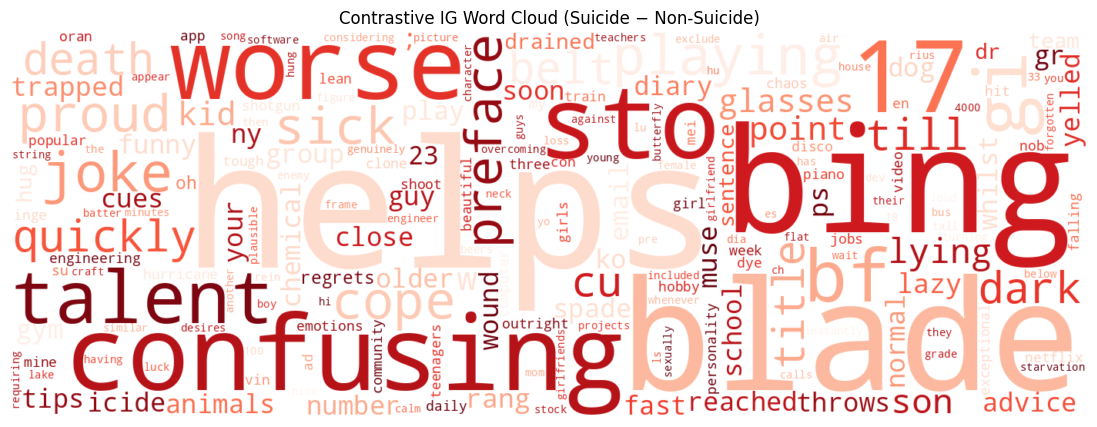

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(
    width=1400,
    height=500,
    background_color="white",
    colormap="Reds"
).generate_from_frequencies(contrastive_ig)

plt.figure(figsize=(14,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Contrastive IG Word Cloud (Suicide − Non-Suicide)")
plt.show()


In [ ]:
top_20_ig = sorted(
    suicide_ig_scores.items(),
    key=lambda x: x[1],
    reverse=True
)[:20]


In [ ]:
import pandas as pd

df_top20_ig = pd.DataFrame(
    top_20_ig,
    columns=["Word", "Avg IG Score"]
)

df_top20_ig


In [ ]:
df_top20_ig["Avg IG Score"] = df_top20_ig["Avg IG Score"].round(4)
df_top20_ig


In [ ]:
df_top20_ig.to_csv("top20_ig_suicide_words.csv", index=False)


####Table X reports the top 20 tokens ranked by average Integrated Gradients attribution for the suicide class. Notably, the model assigns higher importance to latent affective expressions (e.g., ‘hopeless’, ‘alone’, ‘done’) rather than explicit suicide-related terms, indicating reliance on underlying psychological distress cues.”

#ATTENTION × INTEGRATED GRADIENTS (FUSION)